### **Week-7:** Multi-Armed Bandits - MOVIE RECOMMENDATION
### **Name:** Atyam V V R Manoj
### **Reg No. | Sec :** 200968108 | DSE-A 27

**Importing required libraries**

In [1]:
import tensorflow as tf
!pip install tf_agents
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import os
import numpy as np
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 36.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697662 sha256=056f1e178c0108b8182deeb631feec40a36cecaf2ac3293519de313dba7bf18a
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


### **1. Write down the *“Movie Recommendation”* as a Reinforcement Learning problem formulation.**
We can formulate reinforcement learning approaches to building a movie recommendation system as a contextual multi-armed bandit, learning user preferences recommending new movies and receiving their ratings.

*In the context of movie recommendations,*
* **State:** The current state includes the user's profile, including their previous movie choices, ratings, and preferences.

* **Action:** The agent **recommends** a movie to the user based on the current state.

* **Reward:** The reward is the **rating/feedback** given by the user. If the user likes the movie, the reward is positive, and if the user does not like the movie, the reward is negative.

* **Policy:** The policy is the **decision-making process(model training)** that the agent follows to select an action in a given state. The policy should maximize the cumulative reward over the long term.

* **Value function:** The value function is used to estimate the long-term reward that the agent can expect to receive from a given state and action. It can be used to evaluate the quality of the policy and to update it based on experience.

The objective of this problem is to train a policy that maximizes user's satisfaction based on the movies recommended. The agent should be able to adapt to the changes in the reward given by the user and provide the best actions possible.

>Once the policy *(model)* is trained, we can generate actions upon receiving the unseen observation.

In this context, we find another advantage using a reinforcement learning model, which accounts for balance in exploration and exploitation. Not only does the algorithm suggests the users, the content they might find most useful, but it will also suggest some random content, inducing new interest in them.

**Loading the data**

In [2]:
BATCH_SIZE = 8
TRAINING_LOOPS = 1000
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

data_path = '/content/drive/MyDrive/Colab Notebooks/Sem 6 Labs/ml-100k/u.data'
root_dir = '/content/checkpoints'

### **2. For the environment, use the built-in TF-agent, MovieLensPyEnvironment (nonper-arm)**
https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/movielens_py_environment.py

In [ ]:
env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

In [ ]:
# functions to get the optimal rewards
optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)

# functions to get the optimal action
optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

### **3. Compute the regret using the built-in metric in TF-agents**
https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py

In [ ]:
# using the built-in metric for regret
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

### **4. Plot the regret against 20,000-time steps using the built-in agents:**
a.LinUCB 

b. LinTS 

c. NeuralEpsilonGreedy

And identify the best agent for the movie recommendation

In [ ]:
# a. defining LinUCB action method

AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)


# b. defining LinTS action method

lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

# c. defining NeuralEpsilonGreedy action method

EPSILON = 0.03
LAYERS = (50, 50, 50)
LR = 0.005
network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)
neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

In [ ]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lints
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

**Plotting the regret for LinUCB:**

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0, 0.5, 'Average Regret')

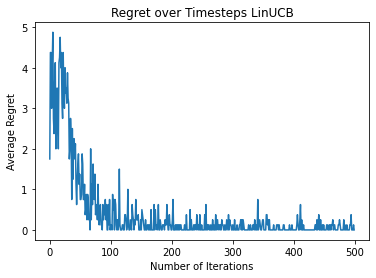

In [ ]:
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [ ]:
sum(regret_values_linucb)

<tf.Tensor: shape=(), dtype=float32, numpy=215.5>

**Plotting the regret for LinTS:**

Text(0, 0.5, 'Average Regret')

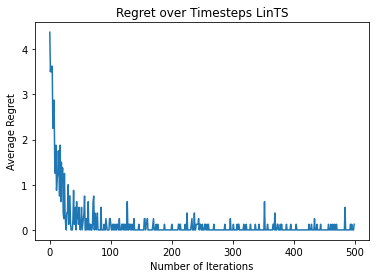

In [ ]:
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [ ]:
sum(regret_values_lints)

<tf.Tensor: shape=(), dtype=float32, numpy=76.5>

**Plotting the regret for NeuralEpsilonGreedy:**

Text(0, 0.5, 'Average Regret')

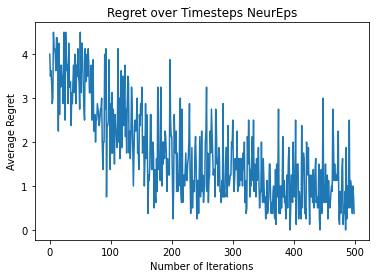

In [ ]:
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [ ]:
sum(regret_values_neureps)

<tf.Tensor: shape=(), dtype=float32, numpy=888.875>

### **Conclusion:**
From the above plots, we can observe that Thompson Sampling**(LinTS)** agent shows the least regret among the other two. So we can conclude it is the best agent among the three.

### **5. Write the Recommendation policy, given a new observation request (i.e. a user vector), the policy will produce actions, which are the recommended movies.**

In [ ]:
# function to recommend movies based on agent and observation
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

In [ ]:
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

13